In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="notebook",font_scale=1.2)
import pandas as pd
# disable setting with copy warning
pd.options.mode.chained_assignment = None
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import pydicom

In [69]:
PV = "age"
if PV == "age":
    groups = ["old", "young"]
else:
    groups = ["male", "female"]
metrics = [
    (f"test/lungOpacity_{groups[0]}_fpr@0.95", f"test/lungOpacity_{groups[1]}_fpr@0.95", "fpr@0.95tpr"),
    (f"test/lungOpacity_{groups[0]}_tpr@0.05", f"test/lungOpacity_{groups[1]}_tpr@0.05", "tpr@0.05fpr"),
    (f"test/lungOpacity_{groups[0]}_anomaly_score", f"test/lungOpacity_{groups[1]}_anomaly_score", "anomaly score"),
    (f"test/lungOpacity_{groups[0]}_AUROC", f"test/lungOpacity_{groups[1]}_AUROC", "AUROC"),
    (f"test/lungOpacity_{groups[0]}_subgroupAUROC", f"test/lungOpacity_{groups[1]}_subgroupAUROC", "subgroupAUROC"),
    (f"test/lungOpacity_{groups[0]}_AP", f"test/lungOpacity_{groups[1]}_AP", "AP")
]
metrics_unwrapped = [item for sublist in [m[0:2] for m in metrics] for item in sublist]

In [70]:
def load_csvs_into_df(dir):
    dirs = [os.path.join(dir,d) for d in os.listdir(dir) if os.path.isdir(os.path.join(dir,d))]
    dfs = []
    sample_dfs = []
    for d in dirs:
        seeds = [f for f in os.listdir(os.path.join('./',d)) if f.startswith('seed')]
        # get last number from directory name
        train_loader_num = int(d.split('_')[-1])
        for seed in seeds:
            results = [f for f in os.listdir(os.path.join(d,seed)) if f.startswith('test_results')][0]
            sample_info = [f for f in os.listdir(os.path.join(d,seed)) if f.startswith('train_loader')][0]
            results_df = pd.read_csv(os.path.join(d, seed, results))
            sample_df = pd.read_csv(os.path.join(d, seed, sample_info))
            results_df["train_loader_num"] = train_loader_num
            sample_df["train_loader_num"] = train_loader_num
            dfs.append(results_df)
            sample_dfs.append(sample_df)
    return pd.concat(dfs, ignore_index=True), pd.concat(sample_dfs, ignore_index=True)

In [71]:
df_1, df_samples_1 = load_csvs_into_df('./2023-10-13 11:56:26-FAE-rsna-age-bs32-dataset-distillation-nsamples1-noDP')
df_1["num_samples"] = 1
df_samples_1["num_samples"] = 1
df_5, df_samples_5 = load_csvs_into_df('./2023-10-13 11:56:26-FAE-rsna-age-bs32-dataset-distillation-nsamples5-noDP')
df_5["num_samples"] = 5
df_samples_5["num_samples"] = 5
df_10, df_samples_10 = load_csvs_into_df('./2023-10-13 11:56:26-FAE-rsna-age-bs32-dataset-distillation-nsamples10-noDP')
df_10["num_samples"] = 10
df_samples_10["num_samples"] = 10
df_15, df_samples_15 = load_csvs_into_df('./2023-10-13 11:56:26-FAE-rsna-age-bs32-dataset-distillation-nsamples15-noDP')
df_15["num_samples"] = 15
df_samples_15["num_samples"] = 15

In [72]:
# combine the dfs
df = pd.concat([df_1,df_5,df_10,df_15], axis=0)
df_samples = pd.concat([df_samples_1,df_samples_5,df_samples_10,df_samples_15], axis=0)

In [73]:
df = df[['seed','protected_attr_percent',*metrics_unwrapped,'num_samples','train_loader_num']]
df = pd.melt(df, id_vars=['seed','protected_attr_percent','num_samples','train_loader_num'])
df = df.loc[(df["variable"]==f"test/lungOpacity_{groups[0]}_subgroupAUROC") | (df["variable"] == f"test/lungOpacity_{groups[1]}_subgroupAUROC")]
df.head()

seed  protected_attr_percent  num_samples  train_loader_num  \
14808     1                     0.5            1              1068   
14809     1                     0.5            1              1071   
14810     1                     0.5            1               502   
14811     1                     0.5            1              1218   
14812     1                     0.5            1               201   

                                 variable   value  
14808  test/lungOpacity_old_subgroupAUROC  0.5882  
14809  test/lungOpacity_old_subgroupAUROC  0.6630  
14810  test/lungOpacity_old_subgroupAUROC  0.5444  
14811  test/lungOpacity_old_subgroupAUROC  0.5446  
14812  test/lungOpacity_old_subgroupAUROC  0.5256

<Axes: xlabel='num_samples', ylabel='value'>

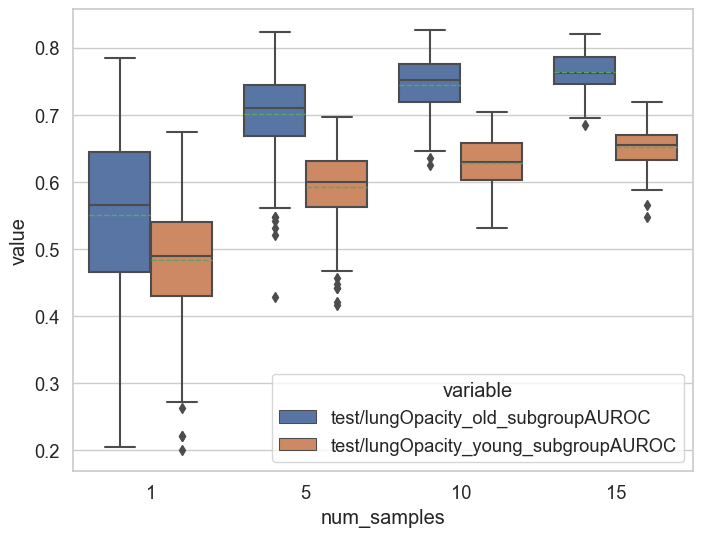

In [74]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="num_samples", y="value", hue="variable", meanline=True, showmeans=True)

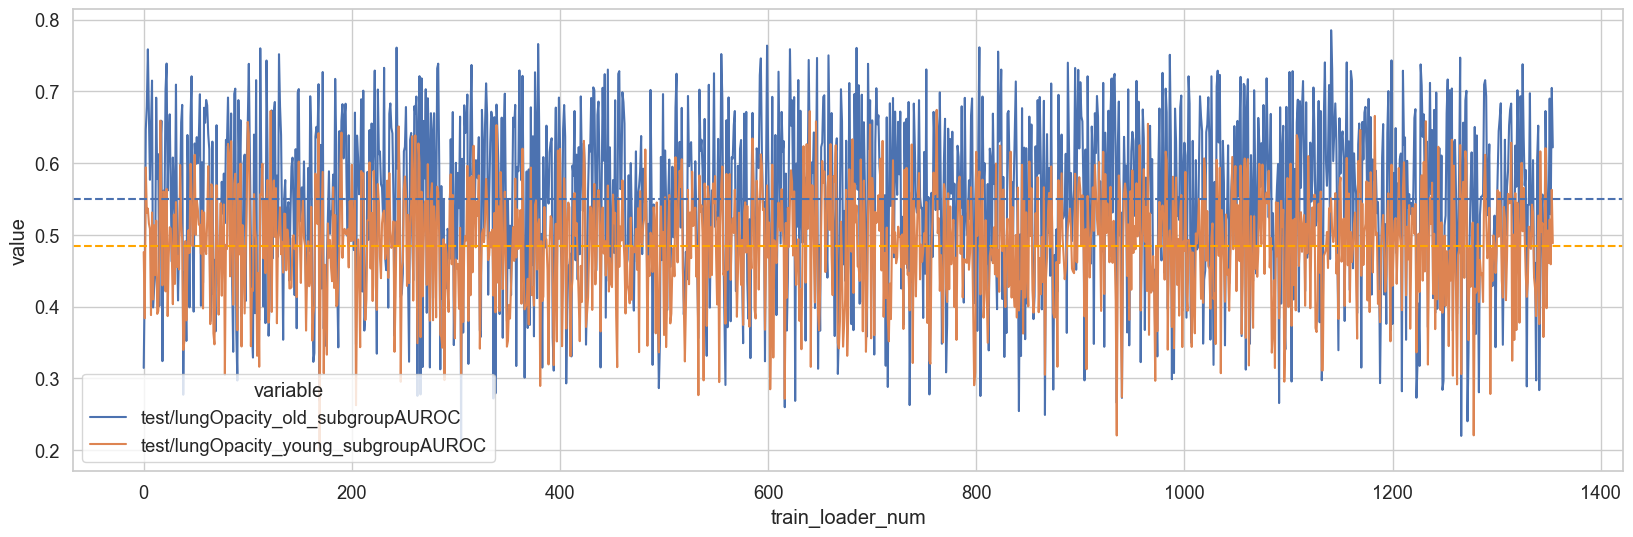

In [75]:
plt.figure(figsize=(20,6))
sub = df.loc[df.num_samples == 1]
sns.lineplot(data=sub, x="train_loader_num", y="value", hue="variable");
# also draw mean lines
plt.axhline(y=sub.loc[sub.variable==f"test/lungOpacity_{groups[0]}_subgroupAUROC"].value.mean(), linestyle='--')
plt.axhline(y=sub.loc[sub.variable==f"test/lungOpacity_{groups[1]}_subgroupAUROC"].value.mean(), color="orange",linestyle='--')

In [76]:
meta_df = pd.read_csv("../../data/csvs/rsna_metadata.csv")
for num_samples in df.num_samples.unique():
    sub = df.loc[df.num_samples == num_samples]
    sub_samples = df_samples.loc[df_samples.num_samples == num_samples]
    for score_var in sub.variable.unique():
        sub_score_var = sub.loc[sub.variable == score_var]
        sub_score_var.sort_values(by="value", ascending=False, inplace=True)
        sub_score_var_top_5 = sub_score_var.train_loader_num.unique()[:50]
        # get filenames
        top_5_file_paths = sub_samples.loc[sub_samples.train_loader_num.isin(sub_score_var_top_5)].filenames.values
        top_5_file_ids = [f.split("/")[-1].split(".")[0] for f in top_5_file_paths]
        top_5_genders = meta_df.loc[meta_df["patientId"].isin(top_5_file_ids)].PatientSex.values
        male_count = sum([i=='M' for i in top_5_genders])
        print(f"For {num_samples} and {score_var} the ratio of male to female is: {np.round(male_count/len(top_5_genders)*100,2)} to {np.round((len(top_5_genders)-male_count)/len(top_5_genders)*100,2)}")
        print("")

For 1 and test/lungOpacity_old_subgroupAUROC the ratio of male to female is: 82.0 to 18.0

For 1 and test/lungOpacity_young_subgroupAUROC the ratio of male to female is: 46.0 to 54.0

For 5 and test/lungOpacity_old_subgroupAUROC the ratio of male to female is: 63.6 to 36.4

For 5 and test/lungOpacity_young_subgroupAUROC the ratio of male to female is: 53.2 to 46.8

For 10 and test/lungOpacity_old_subgroupAUROC the ratio of male to female is: 60.4 to 39.6

For 10 and test/lungOpacity_young_subgroupAUROC the ratio of male to female is: 56.2 to 43.8

For 15 and test/lungOpacity_old_subgroupAUROC the ratio of male to female is: 60.4 to 39.6

For 15 and test/lungOpacity_young_subgroupAUROC the ratio of male to female is: 56.93 to 43.07


In [77]:
def get_best_and_worst(d, d_samples, group=0):
    best = d[["train_loader_num",f"test/lungOpacity_{groups[group]}_subgroupAUROC"]].sort_values(by=f"test/lungOpacity_{groups[group]}_subgroupAUROC", ascending=False).iloc[:5]
    best.rename(columns={f"test/lungOpacity_{groups[group]}_subgroupAUROC":"value"}, inplace=True)
    best.sort_values(by="train_loader_num", ascending=True, inplace=True)
    best_samples = d_samples.loc[d_samples["train_loader_num"].isin(best["train_loader_num"].values)]
    best_samples.sort_values(by="train_loader_num", ascending=True, inplace=True)
    
    worst = d[["train_loader_num",f"test/lungOpacity_{groups[group]}_subgroupAUROC"]].sort_values(by=f"test/lungOpacity_{groups[group]}_subgroupAUROC", ascending=True).iloc[:5]
    worst.rename(columns={f"test/lungOpacity_{groups[group]}_subgroupAUROC":"value"}, inplace=True)
    worst.sort_values(by="train_loader_num", ascending=True, inplace=True)
    worst_samples = d_samples.loc[d_samples["train_loader_num"].isin(worst["train_loader_num"].values)]
    worst_samples.sort_values(by="train_loader_num", ascending=True, inplace=True)
    return best, best_samples, worst, worst_samples

In [78]:
def plot_xrays(d, d_samples, num_imgs=5, group=0, title_prefix=""):
    fig, axs = plt.subplots(1, num_imgs, figsize=(5*num_imgs,num_imgs))
    for i in range(0,num_imgs):
        file_path = d_samples["filenames"].values[i]
        file_path = "../." + file_path
        ds = pydicom.dcmread(file_path)
        axs[i].imshow(ds.pixel_array, cmap=plt.cm.bone)
        # add score as title
        score = d["value"].values[i] if len(d) > 1 else d["value"].values[0]
        axs[i].set_title(f"{title_prefix} {groups[group]} score: {score:.4f}")
        axs[i].grid(False)

In [79]:
def subset_by_trainloader(d,d_samples, train_loader_idx=0):
    chosen_train_loader_num = d.iloc[train_loader_idx]["train_loader_num"]
    d_samples = d_samples.loc[d_samples["train_loader_num"]==chosen_train_loader_num]
    d = d.loc[d["train_loader_num"]==chosen_train_loader_num]
    return d, d_samples

# Details num_samples=1

      train_loader_num   value
617                 16  0.6592
496                122  0.6728
1241               640  0.6724
410                762  0.6742
731               1183  0.6658


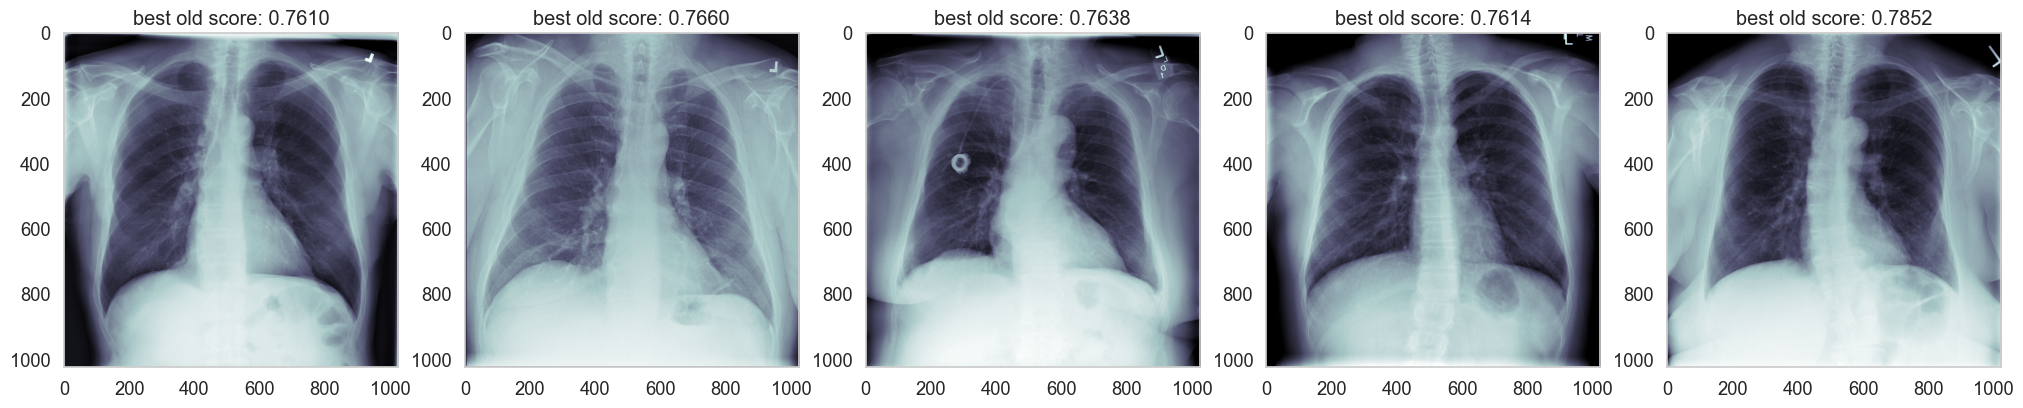

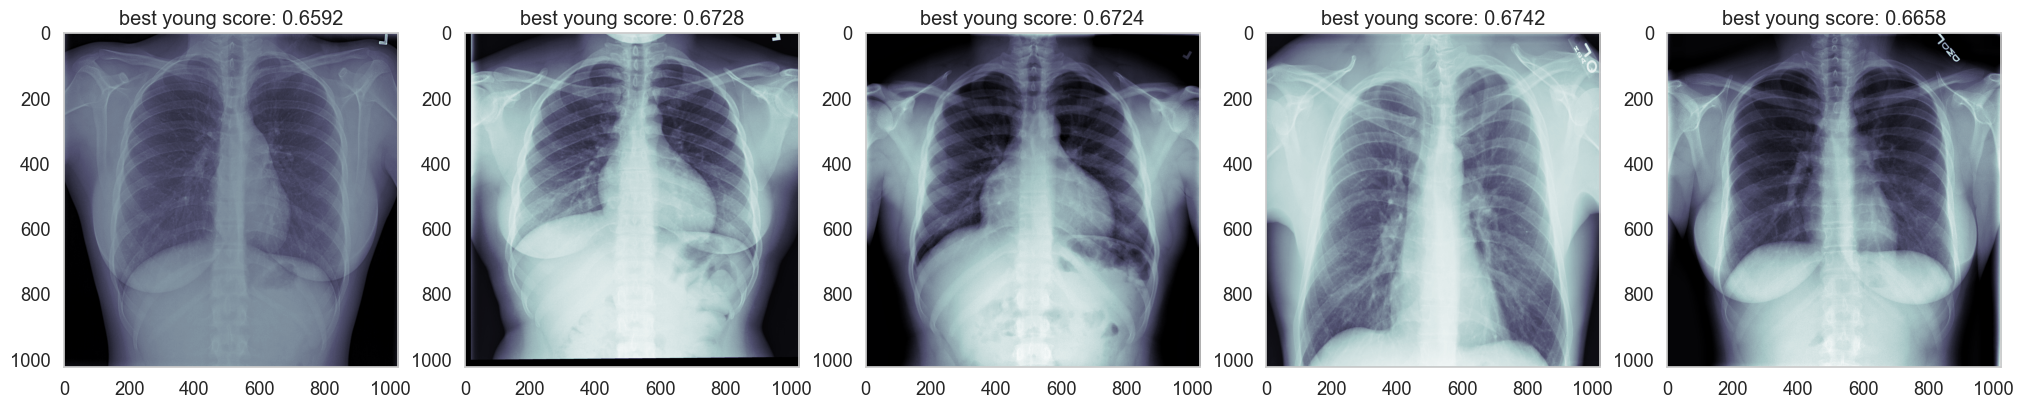

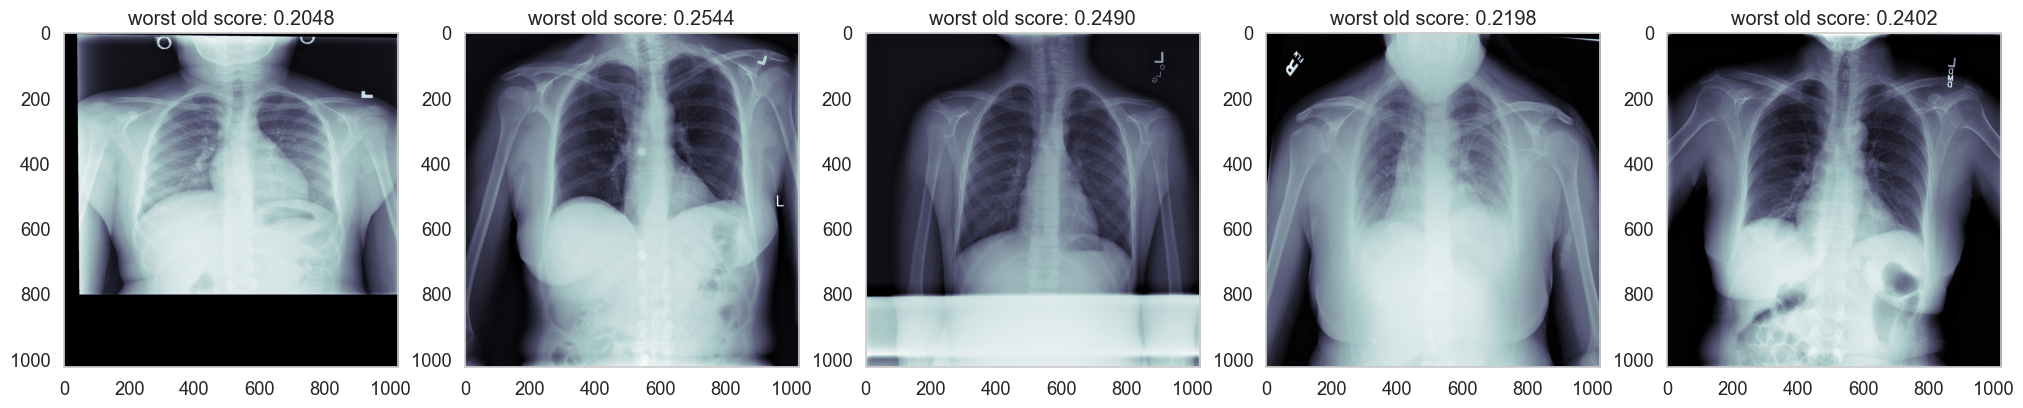

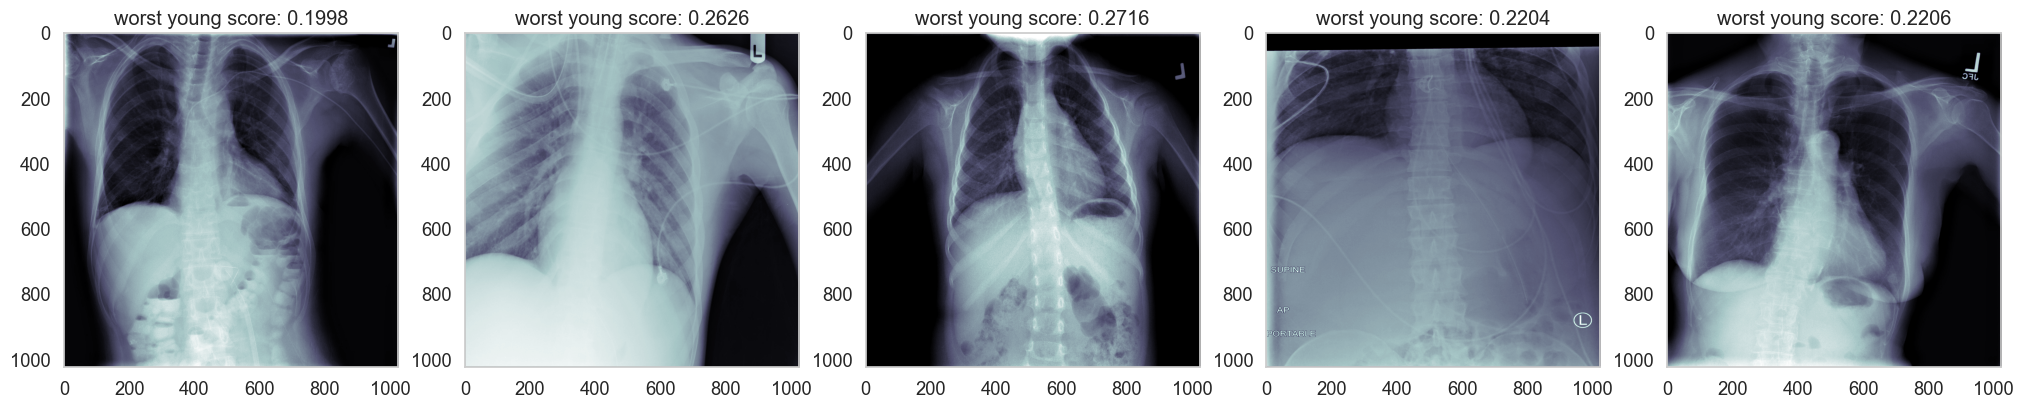

In [80]:
best_old, best_old_samples, worst_old, worst_old_samples = get_best_and_worst(df_1, df_samples_1, group=0)
best_young, best_young_samples, worst_young, worst_young_samples = get_best_and_worst(df_1, df_samples_1, group=1)
print(best_young)
plot_xrays(best_old, best_old_samples, group=0, title_prefix="best")
plot_xrays(best_young, best_young_samples, group=1, title_prefix="best")
plot_xrays(worst_old, worst_old_samples, group=0, title_prefix="worst")
plot_xrays(worst_young, worst_young_samples, group=1, title_prefix="worst")

# Details num_samples=5


Error in callback <function _draw_all_if_interactive at 0x7f18e8a3b880> (for post_execute):


KeyboardInterrupt: 

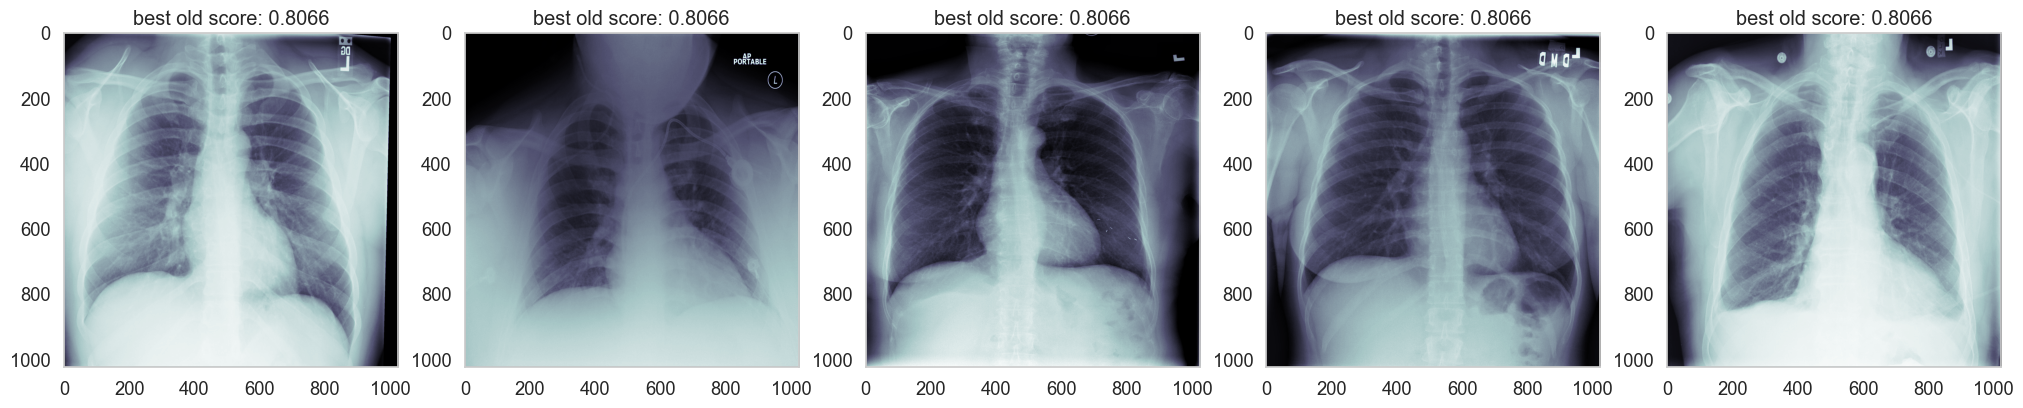

Error in callback <function flush_figures at 0x7f18c486f520> (for post_execute):



KeyboardInterrupt



In [53]:
train_loader_idx = 2
best_old, best_old_samples, worst_old, worst_old_samples = get_best_and_worst(df_5, df_samples_5, group=0)
best_young, best_young_samples, worst_young, worst_young_samples = get_best_and_worst(df_5, df_samples_5, group=1)

best_old, best_old_samples = subset_by_trainloader(best_old, best_old_samples, train_loader_idx=train_loader_idx)
worst_old, worst_old_samples = subset_by_trainloader(worst_old, worst_old_samples, train_loader_idx=train_loader_idx)
best_young, best_young_samples = subset_by_trainloader(best_young, best_young_samples, train_loader_idx=train_loader_idx)
worst_young, worst_young_samples = subset_by_trainloader(worst_young, worst_young_samples, train_loader_idx=train_loader_idx)

plot_xrays(best_old, best_old_samples, group=0, title_prefix="best")
plot_xrays(best_young, best_young_samples, group=1, title_prefix="best")
plot_xrays(worst_old, worst_old_samples, group=0, title_prefix="worst")
plot_xrays(worst_young, worst_young_samples, group=1, title_prefix="worst")

# Details num_samples=10


KeyboardInterrupt: 

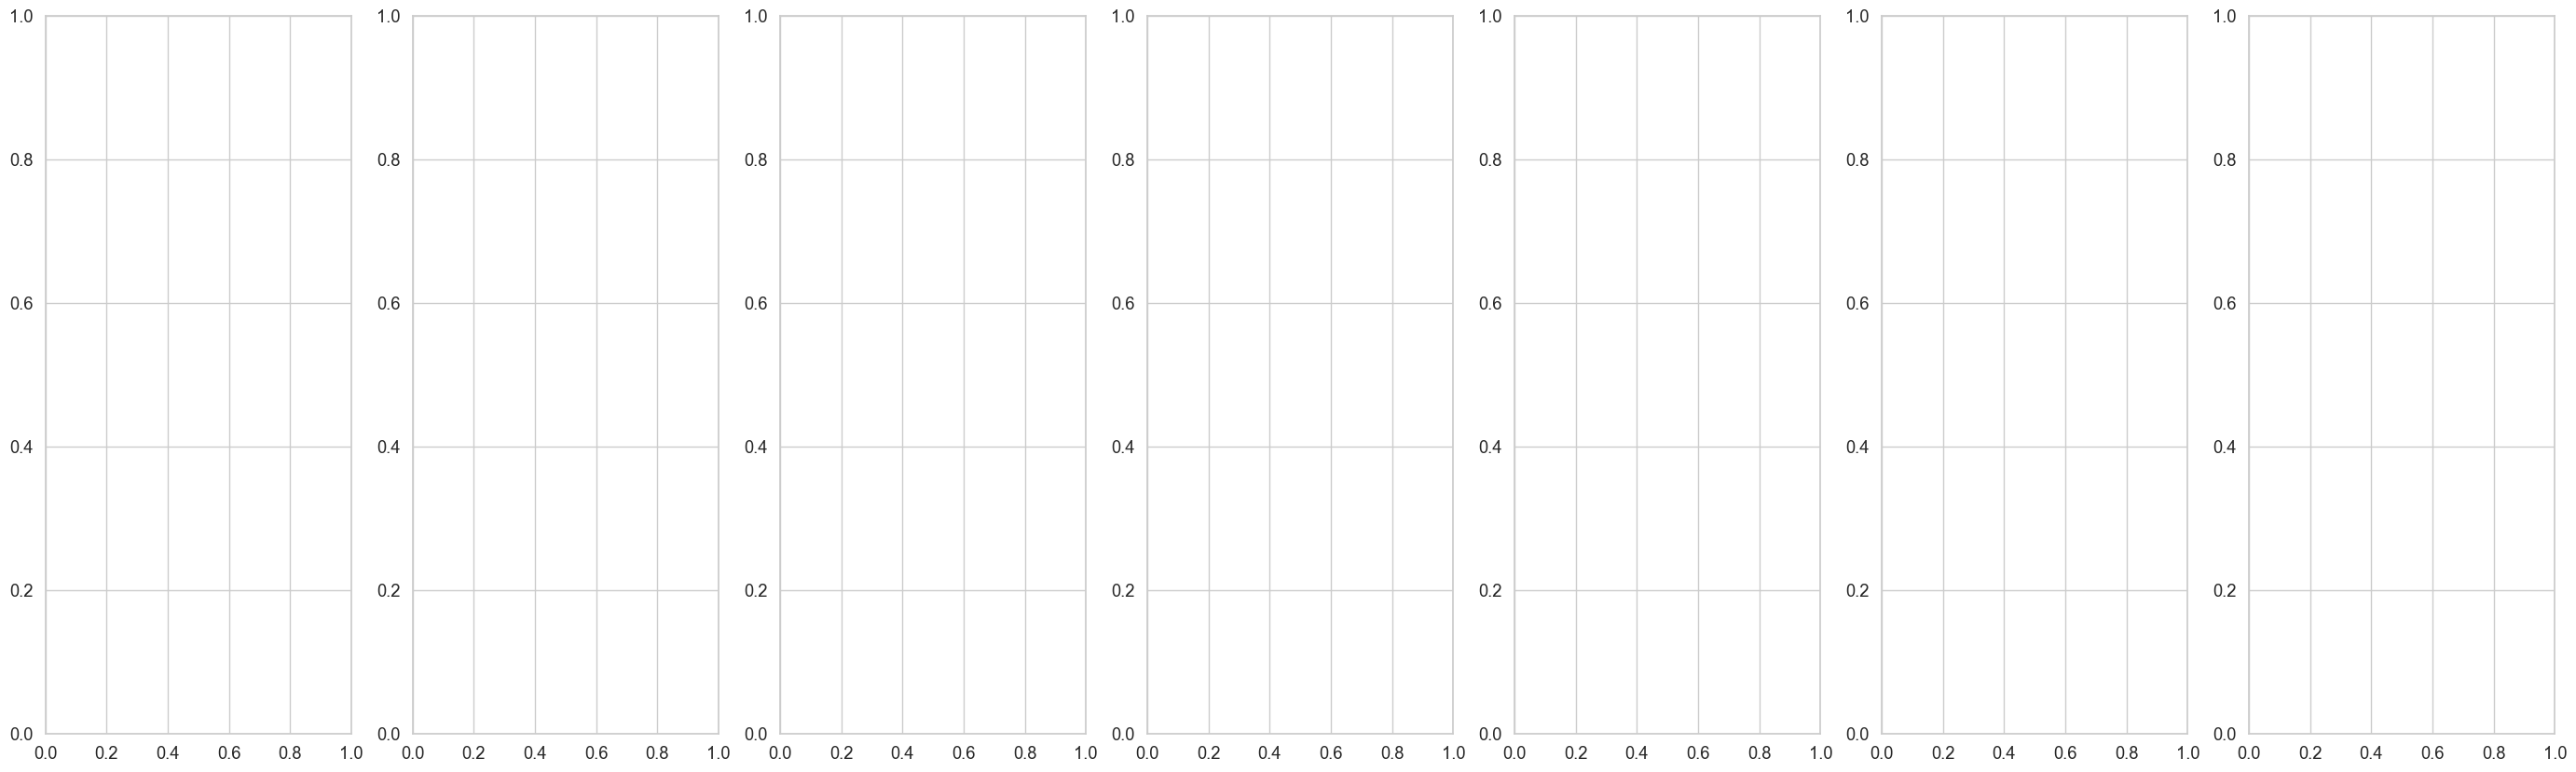

In [54]:
train_loader_idx = 0
best_old, best_old_samples, worst_old, worst_old_samples = get_best_and_worst(df_10, df_samples_10, group=0)
best_young, best_young_samples, worst_young, worst_young_samples = get_best_and_worst(df_10, df_samples_10, group=1)

best_old, best_old_samples = subset_by_trainloader(best_old, best_old_samples, train_loader_idx=train_loader_idx)
worst_old, worst_old_samples = subset_by_trainloader(worst_old, worst_old_samples, train_loader_idx=train_loader_idx)
best_young, best_young_samples = subset_by_trainloader(best_young, best_young_samples, train_loader_idx=train_loader_idx)
worst_young, worst_young_samples = subset_by_trainloader(worst_young, worst_young_samples, train_loader_idx=train_loader_idx)

plot_xrays(best_old, best_old_samples, group=0, title_prefix="best", num_imgs=10)
plot_xrays(best_young, best_young_samples, group=1, title_prefix="best", num_imgs=10)
plot_xrays(worst_old, worst_old_samples, group=0, title_prefix="worst", num_imgs=10)
plot_xrays(worst_young, worst_young_samples, group=1, title_prefix="worst", num_imgs=10)

# Details num_samples=15


In [ ]:
train_loader_idx = 0
best_old, best_old_samples, worst_old, worst_old_samples = get_best_and_worst(df_15, df_samples_15, group=0)
best_young, best_young_samples, worst_young, worst_young_samples = get_best_and_worst(df_15, df_samples_15, group=1)

best_old, best_old_samples = subset_by_trainloader(best_old, best_old_samples, train_loader_idx=train_loader_idx)
worst_old, worst_old_samples = subset_by_trainloader(worst_old, worst_old_samples, train_loader_idx=train_loader_idx)
best_young, best_young_samples = subset_by_trainloader(best_young, best_young_samples, train_loader_idx=train_loader_idx)
worst_young, worst_young_samples = subset_by_trainloader(worst_young, worst_young_samples, train_loader_idx=train_loader_idx)

plot_xrays(best_old, best_old_samples, group=0, title_prefix="best", num_imgs=15)
plot_xrays(best_young, best_young_samples, group=1, title_prefix="best", num_imgs=15)
plot_xrays(worst_old, worst_old_samples, group=0, title_prefix="worst", num_imgs=15)
plot_xrays(worst_young, worst_young_samples, group=1, title_prefix="worst", num_imgs=15)

# Best Samples

In [ ]:
best_samples = []

In [ ]:
df_1_joined = df_1.merge(df_samples_1, on=["train_loader_num"])
relevant_cols = ["train_loader_num", "filenames", "test/lungOpacity_old_subgroupAUROC", "test/lungOpacity_young_subgroupAUROC"]
df_1_joined = df_1_joined[relevant_cols]

In [ ]:
df_1_joined["test/lungOpacity_old_subgroupAUROC"].idxmax()
df_1.iloc[400].train_loader_num

In [ ]:
# get sample with largest subgroupAuroc young and old
df_1_best_young = df_1.loc